Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.utils import pad_sequences
%matplotlib inline

Read Dataset and Preprocessing

In [7]:
df = pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')
df.head()

v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN

In [8]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


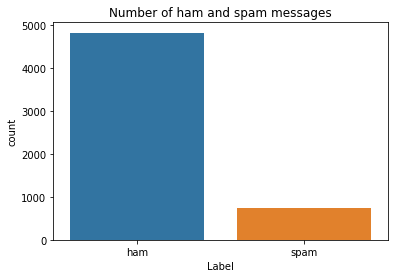

In [9]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [10]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [11]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

Create Model

In [12]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

Adding LSTM Layers

In [13]:
model = RNN()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

Compile The Model

In [14]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Fit The Model

In [15]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
30/30 [==============================] - 13s 281ms/step - loss: 0.3342 - accuracy: 0.8633 - val_loss: 0.1301 - val_accuracy: 0.9810
Epoch 2/10
30/30 [==============================] - 8s 264ms/step - loss: 0.0833 - accuracy: 0.9791 - val_loss: 0.0476 - val_accuracy: 0.9884


Save The Model

In [16]:
model.save('Spam.h5')

Test The Model

In [17]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)
test_sequences_matrix

array([[  0,   0,   0, ...,  18,   5, 136],
       [  0,   0,   0, ...,  84,  33,  89],
       [  0,   0,   0, ..., 475,   2, 306],
       ...,
       [  0,   0,   0, ..., 625,  54, 171],
       [  0,   0,   0, ...,  56,  42,  41],
       [  0,   0,   0, ..., 185, 108, 236]], dtype=int32)

Accuracy Of The Model

In [18]:
accr = model.evaluate(test_sequences_matrix,Y_test)
print('Accuracy:',accr[1])
print('Loss:',accr[0])

27/27 [==============================] - 1s 39ms/step - loss: 0.0614 - accuracy: 0.9821
Accuracy: 0.9820573925971985
Loss: 0.061391204595565796
